### This notebook generates the moisture-precip relationships for MCSs in the idealized RCE simulations.

In [3]:
import numpy as np
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from matplotlib import cm
#import plotly.graph_objects as go
#from plotly.colors import n_colors
#import plotly.io as pio

from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# blue-to-red colormap
BR_color_cycle = ["navy", "blue", "lightskyblue", "tomato", "red", "darkred", "black" ]
data_names = ['RCE 285 K', 'RCE 290 K', 'RCE 295 K', 'RCE 300 K', 'RCE 305 K', 'RCE 310 K', 'ISCCP-ERAI-MSWEP']

## Loading RCE data

In [4]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/'
ssts = np.arange( 285, 316, 5 )

mean_285 = xr.open_dataset( path + 'RCE_COL_MEAN_285.nc' )
mean_290 = xr.open_dataset( path + 'RCE_COL_MEAN_290.nc' )
mean_295 = xr.open_dataset( path + 'RCE_COL_MEAN_295.nc' )
mean_300 = xr.open_dataset( path + 'RCE_COL_MEAN_300.nc' )
mean_305 = xr.open_dataset( path + 'RCE_COL_MEAN_305.nc' )
mean_310 = xr.open_dataset( path + 'RCE_COL_MEAN_310.nc' )

p99_285 = xr.open_dataset( path + 'RCE_COL_99_285.nc' )
p99_290 = xr.open_dataset( path + 'RCE_COL_99_290.nc' )
p99_295 = xr.open_dataset( path + 'RCE_COL_99_295.nc' )
p99_300 = xr.open_dataset( path + 'RCE_COL_99_300.nc' )
p99_305 = xr.open_dataset( path + 'RCE_COL_99_305.nc' )
p99_310 = xr.open_dataset( path + 'RCE_COL_99_310.nc' )

In [5]:
clusters_285 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_285.nc' )
clusters_290 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_290.nc' )
clusters_295 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_295.nc' )
clusters_300 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_300.nc' )
clusters_305 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_305.nc' )
clusters_310 = xr.open_dataset( path + 'RCE_COL_cluster-sizes_310.nc' )
clusters = [clusters_285, clusters_290, clusters_295, clusters_300, clusters_305, clusters_310]
rad = []

for c in clusters:
    rad.append( 2*(c['cluster_sizes']*9/np.pi)**(0.5) )

### Comparing MCS size between RCE and ERA-I datasets

In [6]:
years = np.arange( 1983, 2008 )
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
maxlat_array = nc_open_compile(file_years,"max latitude")
rad_array = nc_open_compile(file_years,"rad")
tropical_indx = np.argwhere( (rad_array <= 550) & (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
#print(len(np.argwhere(rad_array[tropical_indx] >= 600))/len(rad_array[tropical_indx]))
# less than 0.02% of the MCSs have sizes greater than 600

rad_ERAI = negative_to_nan(rad_array)[tropical_indx]
rad.append( rad_ERAI )

In [15]:
# print the 25th and 75th percentiles of each dataset
for j, r in enumerate(rad):
    if j == 6:
        print( len( np.argwhere( r > 350 ) ) )
        print( len( np.argwhere( r > np.percentile(r, 75)) ) )
    print( np.percentile(r, 25), np.percentile(r, 75), np.nanmean(r), np.nanmedian(r) )
    
# and then all of the RCE simulations
rce = []
for r in rad[:6]:
    rce.extend(r)
print( np.percentile(rce, 25), np.percentile(rce, 75) )

98.96824177053246 132.44281687328453 118.94566209444315 110.1600807719705
98.64931585158756 127.01030341787848 116.33960529097914 108.98339889686017
99.15621899026267 139.3776111933682 122.89113039114262 113.81816689081462
100.2480419542482 143.3496809304783 127.15557153651694 116.13533812527172
101.10176588533895 146.69795569923286 128.79656874552387 116.33254357770248
100.61889388516774 155.6976628572032 134.78454562864692 119.897859894389
2749
99861
100.0 143.0 130.82898 116.0
99.73237851104872 141.8328134204998


In [7]:
fig = go.Figure()
fs=22
for r, color, which in zip( rad,  BR_color_cycle, data_names ):
    fig.add_trace( go.Violin(x=r, line_color=color, name=which) )

fig.update_traces( orientation='h', side='positive', width=3, points=False )
fig.update_layout( xaxis=dict(
                      title='MCS effective radius [km]',
                      titlefont=dict(size=fs), showgrid=False, zeroline=False ),
                   yaxis=dict(
                      showticklabels=False ),
                 legend=dict(x=0.95,y=0, xanchor='right', yanchor='bottom', orientation='v', font=dict(size=fs-2) ) )

fig.update_xaxes(range=[50,600],tickfont=dict(size=fs))
fig.show()
#pio.write_image( fig, '/groups/sylvia/JAS-MCS-rain/figures/MCS-size-distribution.pdf', format='pdf' )

[199.41176471]


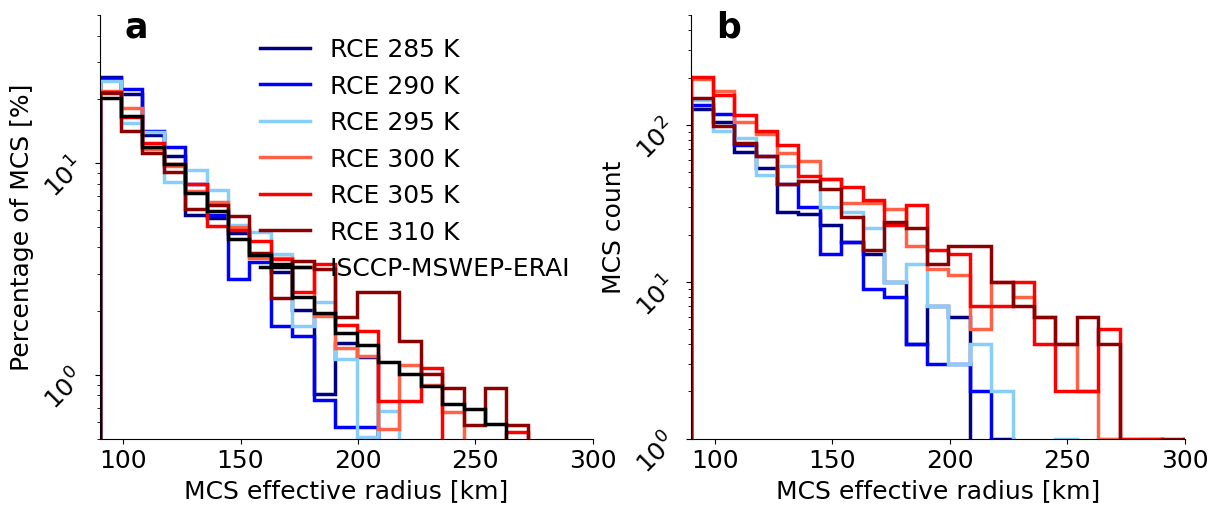

In [5]:
nbin=35
let = ['a', 'b']
clusters = [clusters_285, clusters_290, clusters_295, clusters_300, clusters_305, clusters_310]

font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

fig, ax = plt.subplots( 1, 2, figsize=(14, 5.5) )
for i, c in enumerate(clusters):
    rad = 2*(c['cluster_sizes']*9/np.pi)**(0.5)
    h, edges = np.histogram( rad, bins=np.linspace(90, 400, nbin) )
    wgts = np.ones_like( rad ) / float(len( rad ))*100
    h2, edges2 = np.histogram( rad, bins=np.linspace(90, 400, nbin), weights=wgts)
    
    j = np.argwhere( np.cumsum(h2) > 90 )[0]
    #print(edges2[j]) #At which MCS size, do we exceed the 90th percentile?
    ax[1].stairs( h, edges, edgecolor=BR_color_cycle[i], lw=2.5 )
    ax[0].stairs( h2, edges2, edgecolor=BR_color_cycle[i], lw=2.5, label='RCE ' + str(ssts[i]) +' K'  )
    #sns.kdeplot( rad, ax=ax[0], color=BR_color_cycle[i], lw=2.5, label='RCE ' + str(ssts[i]) +' K' )

wgts = np.ones_like( rad_ERAI ) / float(len( rad_ERAI ))*100
h, edges = np.histogram( rad_ERAI, bins=np.linspace(90, 400, nbin), weights=wgts )
ax[0].stairs( h, edges, edgecolor='k', lw=2.5, label='ISCCP-MSWEP-ERAI', zorder=10 )
#sns.kdeplot( rad_ERAI, ax=ax[0], color='k', lw=2.5, label='ISCCP-MSWEP-ERAI', zorder=10 )

j = np.argwhere( np.cumsum(h) > 90 )[0]
print(edges[j]) #At which MCS size, do we exceed the 90th percentile?
    
for i, a in enumerate(ax):
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    a.set_xlabel( r'MCS effective radius [km]' )
    a.set_xlim( [90, 300] )
    a.set_yscale( 'log' )
    a.tick_params( axis='y', rotation=45 )
    a.text( 0.05, 0.95, let[i], weight='bold', fontsize=25, transform=a.transAxes )
    
ax[1].set_ylabel( 'MCS count' )
ax[0].set_ylabel( 'Percentage of MCS [%]' )
ax[1].set_ylim( [1, 500] )
ax[0].set_ylim( [0.5, 50] )
ax[0].legend( frameon=False )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/MCS-size-distribution.pdf', bbox_inches='tight' )
plt.show()

In [9]:
print(np.linspace(90, 400, nbin))

[ 90.          99.11764706 108.23529412 117.35294118 126.47058824
 135.58823529 144.70588235 153.82352941 162.94117647 172.05882353
 181.17647059 190.29411765 199.41176471 208.52941176 217.64705882
 226.76470588 235.88235294 245.         254.11764706 263.23529412
 272.35294118 281.47058824 290.58823529 299.70588235 308.82352941
 317.94117647 327.05882353 336.17647059 345.29411765 354.41176471
 363.52941176 372.64705882 381.76470588 390.88235294 400.        ]
